# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

### Задание № 1 (4 балла)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier, RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF и SVD. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 8 моделей (два разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF, иначе точно будет слишком долго)

In [160]:
import pandas as pd
import numpy as np

from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

from razdel import tokenize as razdel_tokenize
from string import punctuation
from pymorphy2 import MorphAnalyzer

import gensim

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных, предобработка

In [5]:
data = pd.read_csv('avito_category_classification.csv')

In [6]:
morph = MorphAnalyzer()

# нормализация
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)


In [ ]:
data['description_normalized'] = data['description'].apply(normalize)

In [ ]:
data.head()

,category_name,description,description_normalized
0,Автомобили,"отличное состояние,обслужиание в салоне",отличный состояние обслужиание в салон
1,Детская одежда и обувь,В отличном состоянии. Фирма KIKO. Очень теплый...,в отличный состояние фирма kiko очень тёплый у...
2,Предложение услуг,"Изготовление ограждений, перил,качелей, турник...",изготовление ограждение перила качели турников...
3,Автомобили,Автомобиль в отличном техническом состоянии. О...,автомобиль в отличный технический состояние од...
4,Бытовая техника,"Продается газовая плита ""Гефест"" (Белоруссия) ...",продаваться газовый плита гефест белоруссия б ...


### Pipelines

SVD piplines 

In [ ]:
vectorizer = CountVectorizer(min_df=5, max_df=0.5)

In [ ]:
# Random Forest + SVD
svd_randomforest = Pipeline([
    ('bow', vectorizer),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

# K-NN + SVD
svd_kneighbors = Pipeline([
    ('bow', vectorizer),
    ('svd', TruncatedSVD(500)),
    ('clf', KNeighborsClassifier(n_neighbors=7))
])

# ExtraTrees + SVD
svd_extratrees = Pipeline([
    ('bow', vectorizer),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(random_state=0))
])

# SGD + SVD
svd_sgd = Pipeline([
    ('bow', vectorizer),
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

NMF pipelines

In [ ]:
# Random Forest + NMF
nmf_randomforest = Pipeline([
    ('bow', vectorizer),
    ('svd', NMF(60)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

# K-NN + NMF
nmf_kneighbors = Pipeline([
    ('bow', vectorizer),
    ('svd', NMF(60)),
    ('clf', KNeighborsClassifier(n_neighbors=7))
])

# ExtraTrees + NMF
nmf_extratrees = Pipeline([
    ('bow', vectorizer),
    ('svd', NMF(60)),
    ('clf', ExtraTreesClassifier(random_state=0))
])

# SGD + NMF
nmf_sgd = Pipeline([
    ('bow', vectorizer),
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', NMF(60)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

### Evaluation via Cross Validation

Classification report для кросс-валидации


In [ ]:
# код этой функции взят отсюда:
# https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/topic_modelling/Topic_modelling.ipynb

def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

#### Рассчет метрик для классификаторов с SVD

Random Forest + SVD

In [ ]:
metrics_svd_randomforest, errors_svd_randomforest = eval_table(data['description_normalized'], data['category_name'], svd_randomforest)

In [ ]:
metrics_svd_randomforest

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.90,0.02,0.59,0.06,0.71,0.05
Ремонт и строительство,0.71,0.13,0.10,0.03,0.17,0.05
"Одежда, обувь, аксессуары",0.48,0.01,0.77,0.04,0.59,0.02
Квартиры,0.87,0.04,0.93,0.01,0.90,0.02
Бытовая техника,0.83,0.20,0.07,0.04,0.13,0.07
Детская одежда и обувь,0.47,0.02,0.71,0.03,0.56,0.02
Товары для детей и игрушки,0.88,0.07,0.23,0.03,0.36,0.03
Предложение услуг,0.76,0.04,0.47,0.04,0.58,0.04
Телефоны,0.91,0.06,0.42,0.04,0.58,0.05
Мебель и интерьер,0.85,0.21,0.04,0.03,0.08,0.05


KNN + SVD

In [ ]:
metrics_svd_kneighbors, errors_svd_kneighbors = eval_table(data['description_normalized'], data['category_name'], svd_kneighbors)

In [ ]:
metrics_svd_kneighbors

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.52,0.04,0.65,0.06,0.57,0.02
Ремонт и строительство,0.41,0.09,0.20,0.04,0.26,0.04
"Одежда, обувь, аксессуары",0.52,0.01,0.61,0.02,0.56,0.01
Квартиры,0.95,0.02,0.77,0.04,0.85,0.02
Бытовая техника,0.41,0.10,0.31,0.11,0.35,0.10
Детская одежда и обувь,0.48,0.02,0.68,0.03,0.56,0.02
Товары для детей и игрушки,0.58,0.06,0.30,0.03,0.40,0.02
Предложение услуг,0.70,0.05,0.51,0.04,0.59,0.03
Телефоны,0.75,0.04,0.36,0.05,0.48,0.04
Мебель и интерьер,0.45,0.07,0.29,0.05,0.35,0.05


ExtraTrees + SVD

In [ ]:
metrics_svd_extratrees, errors_svd_extratrees = eval_table(data['description_normalized'], data['category_name'], svd_extratrees)

In [ ]:
metrics_svd_extratrees

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.83,0.04,0.44,0.05,0.57,0.04
Ремонт и строительство,0.64,0.13,0.10,0.02,0.17,0.03
"Одежда, обувь, аксессуары",0.48,0.01,0.73,0.02,0.57,0.01
Квартиры,0.75,0.03,0.83,0.05,0.79,0.04
Бытовая техника,0.63,0.11,0.16,0.03,0.25,0.04
Детская одежда и обувь,0.46,0.01,0.73,0.02,0.56,0.01
Товары для детей и игрушки,0.67,0.04,0.20,0.04,0.30,0.05
Предложение услуг,0.82,0.05,0.28,0.05,0.41,0.06
Телефоны,0.88,0.05,0.37,0.05,0.52,0.05
Мебель и интерьер,0.76,0.07,0.16,0.04,0.26,0.06


SVD + SGD

In [ ]:
metrics_svd_sgd, errors_svd_sgd = eval_table(data['description_normalized'], data['category_name'], svd_sgd)

In [ ]:
metrics_svd_sgd

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.78,0.03,0.86,0.04,0.82,0.01
Ремонт и строительство,0.61,0.08,0.49,0.05,0.54,0.04
"Одежда, обувь, аксессуары",0.71,0.04,0.75,0.04,0.73,0.03
Квартиры,0.94,0.02,0.91,0.02,0.93,0.02
Бытовая техника,0.65,0.05,0.50,0.03,0.56,0.02
Детская одежда и обувь,0.73,0.02,0.79,0.02,0.76,0.01
Товары для детей и игрушки,0.70,0.05,0.68,0.03,0.69,0.02
Предложение услуг,0.82,0.05,0.71,0.07,0.76,0.06
Телефоны,0.80,0.02,0.80,0.04,0.80,0.01
Мебель и интерьер,0.70,0.02,0.60,0.06,0.64,0.04


#### Рассчет метрик для классификаторов с NMF

Random Forest + NMF

In [ ]:
metrics_nmf_randomforest, errors_nmf_randomforest = eval_table(data['description_normalized'], data['category_name'], nmf_randomforest)

In [ ]:
metrics_nmf_randomforest

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.83,0.06,0.78,0.03,0.80,0.04
Ремонт и строительство,0.71,0.08,0.24,0.06,0.35,0.07
"Одежда, обувь, аксессуары",0.50,0.01,0.81,0.01,0.61,0.01
Квартиры,0.93,0.01,0.94,0.02,0.93,0.02
Бытовая техника,0.67,0.52,0.03,0.03,0.06,0.06
Детская одежда и обувь,0.67,0.02,0.67,0.02,0.67,0.02
Товары для детей и игрушки,0.80,0.08,0.46,0.02,0.58,0.03
Предложение услуг,0.69,0.03,0.57,0.09,0.62,0.07
Телефоны,0.78,0.04,0.68,0.03,0.73,0.02
Мебель и интерьер,0.67,0.11,0.31,0.04,0.42,0.05


KNN + NMF

In [ ]:
metrics_nmf_kneighbors, errors_nmf_kneighbors = eval_table(data['description_normalized'], data['category_name'], nmf_kneighbors)

In [ ]:
metrics_nmf_kneighbors

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.51,0.04,0.65,0.05,0.57,0.04
Ремонт и строительство,0.38,0.09,0.17,0.05,0.24,0.06
"Одежда, обувь, аксессуары",0.49,0.02,0.56,0.05,0.52,0.03
Квартиры,0.92,0.02,0.80,0.05,0.85,0.03
Бытовая техника,0.29,0.06,0.19,0.05,0.23,0.05
Детская одежда и обувь,0.45,0.02,0.59,0.01,0.51,0.01
Товары для детей и игрушки,0.53,0.08,0.28,0.07,0.36,0.07
Предложение услуг,0.54,0.08,0.57,0.07,0.55,0.04
Телефоны,0.73,0.09,0.44,0.09,0.55,0.08
Мебель и интерьер,0.27,0.09,0.20,0.07,0.23,0.08


ExtraTrees + NMF

In [ ]:
metrics_nmf_extratrees, errors_nmf_extratrees = eval_table(data['description_normalized'], data['category_name'], nmf_extratrees)

In [ ]:
metrics_nmf_extratrees

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.78,0.04,0.86,0.02,0.81,0.03
Ремонт и строительство,0.61,0.05,0.39,0.05,0.47,0.04
"Одежда, обувь, аксессуары",0.62,0.01,0.71,0.03,0.66,0.02
Квартиры,0.92,0.01,0.96,0.01,0.94,0.01
Бытовая техника,0.54,0.06,0.20,0.05,0.29,0.05
Детская одежда и обувь,0.64,0.02,0.72,0.02,0.67,0.02
Товары для детей и игрушки,0.66,0.03,0.53,0.05,0.59,0.03
Предложение услуг,0.70,0.02,0.76,0.03,0.73,0.02
Телефоны,0.82,0.04,0.73,0.08,0.77,0.04
Мебель и интерьер,0.64,0.05,0.42,0.04,0.50,0.04


SGD + NMF

In [ ]:
metrics_nmf_sgd, errors_nmf_sgd = eval_table(data['description_normalized'], data['category_name'], nmf_sgd)

In [ ]:
metrics_nmf_sgd

,precision,precision_std,recall,recall_std,f1,f1_std
Автомобили,0.74,0.08,0.82,0.06,0.78,0.03
Ремонт и строительство,0.53,0.11,0.30,0.12,0.36,0.04
"Одежда, обувь, аксессуары",0.51,0.09,0.48,0.20,0.47,0.12
Квартиры,0.85,0.06,0.95,0.03,0.89,0.04
Бытовая техника,0.59,0.09,0.26,0.12,0.34,0.09
Детская одежда и обувь,0.49,0.07,0.56,0.14,0.51,0.07
Товары для детей и игрушки,0.66,0.06,0.55,0.06,0.59,0.02
Предложение услуг,0.60,0.04,0.65,0.03,0.62,0.02
Телефоны,0.69,0.19,0.62,0.10,0.62,0.08
Мебель и интерьер,0.45,0.12,0.31,0.14,0.33,0.10


### Сравнение метрик. Выбор лучшей модели

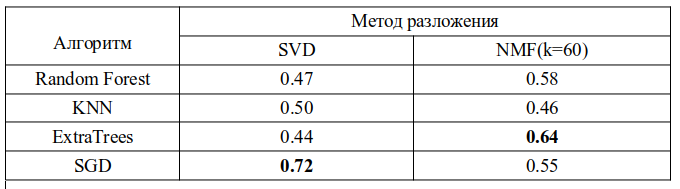
<br>
*Таблица с усредненными значениями F-меры для полученных моделей.*


Лучшее качество показала модель SGD + SVD (F1 = 0.72). Для алгоритмов на основе деревьев решений (Random Forest, ExtraTrees) разложение NMF подошло лучше, чем SVD.




### Задание № 2 (6 баллов)

В Gensim тоже можно добавить нграммы и tfidf. Постройте 1 модель без них (как в семинаре) и еще 3 модели (1 с нграммами, 1 с tfidf и 1 с нграммами и с tfidf). Сранивте качество с помощью метрик (перплексия, когерентность) и на глаз. Определите лучшую модель. Для каждой модели выберите 1 самую красивую на ваш взгляд тему.

Используйте данные википедии из семинара. Можете взять поменьше данных, если все обучается долго.

Важное требование - получившиеся модели не должны быть совсем плохими. Если хороших тем не получается, попробуйте настроить гиперпараметры, отфильтровать словарь по-другому. 

### Model 1. Unigrams

In [95]:
texts = open('wiki_data.txt').read().splitlines()[:5000]

In [96]:
texts_norm = ([normalize(text) for text in texts])

In [97]:
# словарь id->word
id2word_dict1 = gensim.corpora.Dictionary((text.split() for text in texts_norm))

#фильтрация редких и частотных слов
id2word_dict1.filter_extremes(no_above=0.1, no_below=10)
id2word_dict1.compactify()

# преобразование текстов мешки слов
corpus1 = [id2word_dict.doc2bow(text.split()) for text in texts_norm]

In [124]:
lda1 = gensim.models.LdaMulticore(corpus1, 
                                 100, # число тем
                                 alpha='asymmetric',
                                 id2word=id2word_dict1, 
                                 passes=10) 

### Model 2. N-gramms (collocations) + BoW

In [25]:
texts_ngrams = [text.split() for text in texts_norm]
ph = gensim.models.Phrases(texts_ngrams, scoring='npmi', threshold=0.4) # threshold можно подбирать
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts_ngrams] 

В ngrammed_texts хранятся слова + выявленные Gensim коллокации (словосочетания/n-граммы)

In [35]:
[text[:15] for text in ngrammed_texts[:1]]

[['новостройка',
  'нижегородский_область',
  'новостро́йка',
  '—',
  'сельский',
  'посёлок',
  'в',
  'дивеевский_район',
  'нижегородский_область',
  'входить',
  'в',
  'состав_сатисский',
  'сельсовет',
  'посёлок',
  'расположить']]

Составим словарь с учетом выявленных n-грамм

In [48]:
id2word_dict2 = gensim.corpora.Dictionary((ngrammed_texts))

id2word_dict2.filter_extremes(no_above=0.1, no_below=10)
id2word_dict2.compactify()

corpus2 = [id2word_dict2.doc2bow(text) for text in ngrammed_texts]

In [47]:
id2word_dict2[500]

'железнодорожный_линия'

Обучим модель

In [49]:
lda2 = gensim.models.LdaMulticore(corpus2, 
                                 100, # число тем
                                 alpha='asymmetric',
                                 id2word=id2word_dict2, 
                                 passes=10) 

## Model 3. Unigrams + TF-IDF

In [102]:
# тут пришлось уменьшить размер датасета
texts_small = open('wiki_data.txt').read().splitlines()[:3000]

In [103]:
texts_norm_small = ([normalize(text) for text in texts_small])

In [104]:
# словарь id->word
id2word_dict3 = gensim.corpora.Dictionary((text.split() for text in texts_norm_small))

#фильтрация редких и частотных слов
id2word_dict3.filter_extremes(no_above=0.1, no_below=10)
id2word_dict3.compactify()

# преобразование текстов мешки слов
corpus3 = [id2word_dict3.doc2bow(text.split()) for text in texts_norm_small]

In [105]:
# добавим TF-IDF
# corpus и id2word_dict взяты из первой модели

tfidf = gensim.models.TfidfModel(corpus3)
corpus3 = [tfidf[text] for text in corpus3]

Обучим модель с учетом TF-IDF

In [106]:
lda3 = gensim.models.LdaMulticore(corpus3, 
                                 100, # число тем
                                 alpha='asymmetric',
                                 id2word=id2word_dict3, 
                                 passes=10) 

In [ ]:
lda3.print_topics()

## Model 4. N-grams vs TF-IDF

In [73]:
# TF-IDF получим из корпуса N-грамм в модели 2
tfidf = gensim.models.TfidfModel(corpus2)
corpus4 = [tfidf[text] for text in corpus2]

In [165]:
lda4 = gensim.models.LdaMulticore(corpus4, 
                                 100, # число тем
                                 alpha='asymmetric',
                                 id2word=id2word_dict2, 
                                 passes=2) 

### Анализ результатов, оценка качества




### Перплексия
Unigrams + BoW: -7.999
<br>
N-grams + BoW: -8.312
<br>
Unigrams + TF-IDF: -10.770
<br>
N-grams + TF-IDF: -13.679
<br>
<br>
Чем ниже значение перплексии — тем лучше моделируемость корпуса. Среди 4-х моделей наименьшее значение перплексии соответствует модели N-grams + TF-IDF. 

### Когерентность
Unigrams + BoW: 0.538
<br>
N-grams + BoW: —
<br>
Unigrams + TF-IDF: 0.514
<br>
N-grams + TF-IDF: — 
<br>
<br>
Почему-то подсчет когерентности не сработал для моделей на основе n-gramm (возвращался nan). Если сравнивать модели с униграмами, то когерентность у модели с мешком слов чуть выше. Однако разница в метриках не особо значительна.

### Анализ полученных тематик 

На мой взгляд, все модели показали неплохую способность выявлять темы в текстах. 

При параметре passes=10 для модели на основе N-грамм и TF-IDF было очень сложно интерпретировать результат, так как было много несвязных слов. Поэтому для этой модели параметр passes был снижен. 

Лучшая тематика для модели Unigrams + BoW:
<br>
*армия + войско + фронт + противник + бой + операция + наступление + 1-й + оборона + сила*
<br>
Предположительная тематика: армия/война
<br>
<br>
Лучшая тематика для модели N-grams + BoW:
<br>
*замок + литовский + башня + князь + брат + княжество + московский + великий князь + век + великий княжество*
<br>
Предположительная тематика: история
<br><br>
Лучшая тематика для модели Unigrams + TF-IDF:
<br>
*годовщина + music + держаться + entertainment + агентство + участник + сингл + альбом + выпустить + японский*
<br>
Предположительная тематика: музыка
<br><br>
Лучшая тематика для модели N-grams + TF-IDF:
<br>
*звезда + обсерватория + величина + звёздный + астрономия + атлас + обозрение + хельсинки*
<br>
Предположительная тематика: астрономия
<br>

### Какая из 4-х моделей лучше всех?

Сложно однозначно сказать, какая из 4-х моделей показала лучший результат. Однако тематики самой простой модели Unigrams + BoW мне показались самыми понятными. Также когерентность у этой модели выше, чем у модели с TF-IDF.

Рассчет перплексии

In [167]:
print(lda1.log_perplexity(corpus1))
print(lda2.log_perplexity(corpus2))
print(lda3.log_perplexity(corpus3))
print(lda4.log_perplexity(corpus4))


-7.998590855930469
-8.319090654720284
-10.770508108999966
-13.679726548470425


Рассчет когерентности

In [136]:
def get_coherence(lda, texts_norm, id2word_dict):
  topics = []
  for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
  
  coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts_norm], 
                                                   dictionary=id2word_dict, coherence='c_v')
  
  return coherence_model_lda.get_coherence()

In [141]:
print(get_coherence(lda1, texts_norm, id2word_dict1))
# для моделей с n-граммами возвращается nan
print(get_coherence(lda2, texts_norm, id2word_dict2))
print(get_coherence(lda3, texts_norm_small, id2word_dict3))
# тоже выводит nan (модель с n-граммами)
print(get_coherence(lda4, texts_norm, id2word_dict2))

0.5384452978323155
nan
0.513562688825104
nan


Вывод полученных тематик

In [142]:
lda1.print_topics()

[(99,
  '0.022*"театр" + 0.015*"азербайджанский" + 0.014*"музыкальный" + 0.010*"азербайджан" + 0.009*"балет" + 0.009*"опера" + 0.008*"баку" + 0.007*"александр" + 0.006*"сергей" + 0.006*"музыка"'),
 (98,
  '0.026*"остров" + 0.023*"1972" + 0.017*"багамский" + 0.014*"авианосец" + 0.014*"воздух" + 0.012*"сша" + 0.011*"вывести" + 0.011*"uss" + 0.011*"самолёт" + 0.011*"строй"'),
 (97,
  '0.024*"крест" + 0.014*"церковь" + 0.014*"святой" + 0.011*"полярный" + 0.010*"капитан" + 0.010*"измерение" + 0.009*"кладбище" + 0.008*"св" + 0.007*"вера" + 0.007*"команда"'),
 (95,
  '0.015*"михаил" + 0.011*"томас" + 0.009*"дело" + 0.008*"ссср" + 0.008*"ян" + 0.007*"советский" + 0.006*"язык" + 0.006*"отношение" + 0.006*"член" + 0.006*"сын"'),
 (94,
  '0.026*"wwe" + 0.023*"титул" + 0.022*"матч" + 0.022*"шоу" + 0.020*"победа" + 0.017*"бой" + 0.016*"одержать" + 0.014*"против" + 0.013*"чемпион" + 0.012*"девушка"'),
 (96,
  '0.049*"армия" + 0.048*"войско" + 0.030*"фронт" + 0.024*"противник" + 0.019*"бой" + 0.015*"

In [143]:
lda2.print_topics()

[(99,
  '0.021*"6" + 0.014*"численность_население" + 0.012*"река" + 0.012*"составлять" + 0.011*"ворота" + 0.010*"7" + 0.007*"симфония" + 0.007*"рига" + 0.007*"1989" + 0.007*"8"'),
 (98,
  '0.018*"южный_полюс" + 0.016*"меридиан_восточный" + 0.014*"северный_полюс" + 0.012*"долгота" + 0.011*"градус" + 0.010*"аэропорт" + 0.007*"тихий_океан" + 0.007*"звено" + 0.007*"северный_ледовитый" + 0.006*"фильм"'),
 (96,
  '0.014*"станция" + 0.013*"комплекс" + 0.009*"ремонт" + 0.008*"эксперимент" + 0.008*"цех" + 0.007*"о_’" + 0.006*"сфера" + 0.006*"выполнение" + 0.006*"земля" + 0.006*"луна"'),
 (97,
  '0.014*"мочь" + 0.007*"например" + 0.006*"случай" + 0.006*"использовать" + 0.006*"если" + 0.006*"некоторый" + 0.005*"форма" + 0.005*"использоваться" + 0.005*"можно" + 0.005*"вода"'),
 (95,
  '0.053*"село" + 0.014*"школа" + 0.013*"церковь" + 0.009*"житель" + 0.009*"иметься" + 0.007*"население" + 0.007*"колхоз" + 0.006*"сельский" + 0.006*"земля" + 0.006*"крестьянин"'),
 (94,
  '0.008*"птица" + 0.008*"цвет"

In [144]:
lda3.print_topics()

[(99,
  '0.000*"поляк" + 0.000*"польша" + 0.000*"сборная" + 0.000*"чемпионат" + 0.000*"матч" + 0.000*"подавлять" + 0.000*"команда" + 0.000*"решающий" + 0.000*"польский" + 0.000*"групповой"'),
 (97,
  '0.000*"фронт" + 0.000*"авиационный" + 0.000*"гвардия" + 0.000*"вылет" + 0.000*"боевой" + 0.000*"полка" + 0.000*"1945" + 0.000*"армия" + 0.000*"младший" + 0.000*"сбить"'),
 (98,
  '0.000*"48" + 0.000*"160" + 0.000*"станица" + 0.000*"северокавказский" + 0.000*"дубовский" + 0.000*"донской" + 0.000*"динамика" + 0.000*"возвышенность" + 0.000*"андреевский" + 0.000*"хутор"'),
 (96,
  '0.000*"партия" + 0.000*"ян" + 0.000*"иванович" + 0.000*"сын" + 0.000*"итальянский" + 0.000*"р" + 0.000*"социальный" + 0.000*"жена" + 0.000*"правый" + 0.000*"движение"'),
 (95,
  '0.000*"годовщина" + 0.000*"music" + 0.000*"держаться" + 0.000*"entertainment" + 0.000*"агентство" + 0.000*"участник" + 0.000*"сингл" + 0.000*"альбом" + 0.000*"выпустить" + 0.000*"японский"'),
 (94,
  '0.000*"48" + 0.000*"160" + 0.000*"стан

In [166]:
lda4.print_topics()

[(98,
  '0.005*"неприятель" + 0.004*"сражение" + 0.004*"генерал" + 0.004*"поручение" + 0.004*"возвратиться" + 0.003*"комендант" + 0.003*"1813" + 0.003*"наполеон" + 0.003*"историк" + 0.002*"квартира"'),
 (99,
  '0.001*"остров" + 0.000*"григорий" + 0.000*"нью-йорк" + 0.000*"шрифт" + 0.000*"мост" + 0.000*"спектакль" + 0.000*"режиссёр" + 0.000*"психологический" + 0.000*"голландский" + 0.000*"съёмка"'),
 (97,
  '0.011*"р" + 0.006*"десятина" + 0.005*"верста" + 0.004*"земский" + 0.004*"тыс" + 0.003*"картофель" + 0.002*"кукуруза" + 0.002*"волокно" + 0.002*"долг" + 0.002*"усиливаться"'),
 (95,
  '0.013*"ким" + 0.010*"картина" + 0.008*"ирина" + 0.006*"альбом" + 0.006*"злодей" + 0.005*"личинка" + 0.005*"рыба" + 0.005*"изобразить" + 0.005*"хозяин" + 0.004*"записывать"'),
 (96,
  '0.001*"животное" + 0.000*"мясо" + 0.000*"мочь" + 0.000*"смотреть" + 0.000*"скот" + 0.000*"пища" + 0.000*"корова" + 0.000*"потребление" + 0.000*"хвост" + 0.000*"некоторый"'),
 (94,
  '0.001*"песня" + 0.001*"композиция" + 0